In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.optim as optim
import pickle
import torch.nn as nn
from nice.algorithms.connectivity_AT import *
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import gaussian_filter1d

c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


In [2]:
file_numbers = [1]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}

def smooth_with_gaussian(data, sigma=5):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

def preprocess(data):
    #data shape: (trials, time, neurons)
    trials, time, num_neurons = data.shape
    z = np.zeros_like(data)

    for neuron in range(num_neurons):
        for t in range(time):
            vals = data[:, t, neuron]  #this is all the data for given neuron at given time point
            std = np.std(vals)
            if std > 1e-6:
                z[:, t, neuron] = (vals - np.mean(vals)) / std    #zscore if there is a stdev
            else:
                z[:, t, neuron] = np.median(vals)   #returnt the median value otherwise  (median rather than mean in case of large variability in a singel point)

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z

def get_shared_active_neurons(*arrays):
    combined_activity = np.zeros(arrays[0].shape[-1], dtype = bool)

    for arr in arrays:
        activity = arr.sum(axis = (0, 1)) != 0  
        combined_activity |= activity 

    return combined_activity


def get_data(file_number):
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    data = pickle.load(open(file_path, 'rb'))
  
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]  #for class of input
    attend_01 = data['attend'][0]
    omitted = data['omit'][0]
    relevant = np.where(omitted == 0)[0]
    left_inputs_SP = data['SP'][0][0][relevant]
    right_inputs_SP = data['SP'][0][1][relevant]
    attention_inputs_SP = data['SP'][0][2][relevant]
    #shapes 1057, 500, 160/80)

    # Define the time segment of interest
    time_segment = slice(100, 350)

    # Count the number of spikes per neuron in the left, right, and attention layers within the time segment
    left_spike_count_per_neuron = np.sum(left_inputs_SP[:, time_segment, :], axis=1)  # Sum over the time segment
    right_spike_count_per_neuron = np.sum(right_inputs_SP[:, time_segment, :], axis=1)
    attention_spike_count_per_neuron = np.sum(attention_inputs_SP[:, time_segment, :], axis=1)

    # Filter indices for left and right attentional modes
    left_indices_agg = np.where((omitted == 0) & (attend_01 == 0) & (label_left != label_right))[0]
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices=True)

    right_indices_agg = np.where((omitted == 0) & (attend_01 == 1) & (label_left != label_right))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices=True)

    # Extract spike counts per neuron for each attentional mode within the time segment
    left_attleft = left_spike_count_per_neuron[left_indices]
    left_attright = right_spike_count_per_neuron[right_indices]
    right_attleft = left_spike_count_per_neuron[left_indices]
    right_attright = right_spike_count_per_neuron[right_indices]
    att_attleft = attention_spike_count_per_neuron[left_indices]
    att_attright = attention_spike_count_per_neuron[right_indices]

    num_trials_left = len(left_indices)
    num_trials_right = len(right_indices)

    return left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, num_trials_left, num_trials_right

l_al = []
l_ar = []
r_al = []
r_ar = []
a_al = []
a_ar = []

def collect_data(file_numbers):
    for file_number in file_numbers:
        left_attleft, left_attright, right_attleft, right_attright, att_attleft, att_attright, _, _, = get_data(file_number)
        l_al.append(left_attleft)
        l_ar.append(left_attright)
        r_al.append(right_attleft)
        r_ar.append(right_attright)
        a_al.append(att_attleft)
        a_ar.append(att_attright)
       
    return l_al, l_ar, r_al, r_ar, a_al, a_ar
   

In [3]:
#file_numbers = [1, 2, 4, 8, 14, 15, 20, 23] #for the full dataset
l_al, _, _, _, a_al, _ = collect_data(file_numbers = [1, 2, 4])

In [ ]:
print((l_al[0].shape), (a_al[0].shape))

print(l_al[0][0])


def norm_data(data):
    for i in range(len(data)):
        for j in range(len(data[i])):
            count = np.sum(data[i][j])
            if count > 0:
                data[i][j] = data[i][j] / count
            else:
                data[i][j] = 0
    return data



(468, 160) (468, 80)
[0.03957784 0.00659631 0.         0.         0.         0.01187335
 0.         0.         0.00131926 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.01055409 0.         0.         0.         0.         0.03298153
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00131926 0.
 0.07387863 0.         0.00395778 0.         0.00263852 0.
 0.01846966 0.         0.         0.         0.         0.
 0.00131926 0.00263852 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00527704
 0.00263852 0.         0.         0.         0.         0.
 0.         0.         0.         0.02770449 0.         0.0237467
 0.         0.         0.00791557 0.         0.         0.
 0.         0.         0.         0.         0.         0.00263852
 0.         0.         0.         0.         0.        

want to now make this into the appropriate input vector for MVPA
x will have n_total_trial inputs, each vector will have one of the 80 or 160 neurons as basis vector, and values of those vectors at each time point, e.g. 500 vectors each of length (80, 1) 

the goal will be to train 4 models
left input x predicting attention y when attention is left
right input x when predicting attention y when attention is right
"" same but for attention right

can then compare the r^2, mean square error, model weights, feature importance etc

will need [trials, n_features]

will be good to just shuffle the data and analyse the null distribution

In [27]:
def prep_data(x, y, batch_size = 16, shuffle = True):
    x = np.concatenate(x, axis = 0)
    y = np.concatenate(y, axis = 0)
    print(x.shape)
    print(y.shape)
    x = torch.tensor(x, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    print(x.shape)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.2, random_state=42, shuffle=True)

    train_dataset = TensorDataset(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True, num_workers=0)
    return train_loader, x_test, y_test, x_validation, y_validation

class SpikingAttentionLSTM(nn.Module):
    def __init__(self, input_dim = 160, hidden_dim = 128, output_dim = 80, num_layers = 2, dropout = 0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size = input_dim,
            hidden_size = hidden_dim, 
            batch_first = True,
            num_layers = num_layers,
            dropout = dropout if num_layers > 1 else 0.0,  #dropout only applies if num_layers > 1

        )
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)  # Dropout layer

    def forward(self, x):
        output, _ = self.lstm(x) #shape (batch_size, 500, hidden_dim)
        dropped = self.dropout(output)  #applies dropout to the LSTM output
        out = self.fc(dropped)
        return out   #this will be shape (batch_size, 500, 80)
    
class SpikingAttentionSkipConnection(nn.Module):
    def __init__(self, input_dim=160, hidden_dim=128, output_dim=80, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim + input_dim, output_dim)  #skip connection
     

    def forward(self, x):
        lstm_out, _ = self.lstm(x)             #(batch, time, hidden)
        concat = torch.cat([lstm_out, x], dim=-1)  #(batch, time, hidden + input)
        output = self.fc(concat)               #(batch, time, output)
        return output


def correlation_loss(pred, target):
    vx = pred - pred.mean(dim=1, keepdim=True)
    vy = target - target.mean(dim=1, keepdim=True)
    corr = (vx * vy).mean(dim=1) / (vx.std(dim=1) * vy.std(dim=1) + 1e-6)
    return 1 - corr.mean()

mse_loss = nn.MSELoss()

def combined_loss(pred, target, alpha=0.8):
    return alpha * correlation_loss(pred, target) + (1 - alpha) * mse_loss(pred, target)


def train(model, train_loader, x_val, y_val, 
           criterion, epochs=1000, clip_value = 1.0, 
           lr = 0.001, patience = 20):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_history = []
    validation_loss_history = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_since_improvement = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)  #gradient clipping
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)

        model.eval()
        with torch.no_grad():
            y_val_pred = model(x_val)
            val_loss = criterion(y_val_pred, y_val)
            val_loss_item = val_loss.item()
            validation_loss_history.append(val_loss.item())

        #early stopping
        if val_loss_item < best_val_loss:
            best_val_loss = val_loss_item
            best_model_state = model.state_dict()
            epochs_since_improvement = 0
        else:
            epochs_since_improvement += 1

            

        if epoch % 10 == 0:
            clear_output(wait=True)  #clears the Jupyter output cell
            plt.figure(figsize=(10, 7))
            plt.plot(loss_history, label = 'Training Loss')
            plt.plot(validation_loss_history, label = 'Validation Loss')
            plt.legend()
            plt.xlim(0, epochs)
            plt.ylim(0, 0.7)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.grid(True)
            plt.show()

        if epochs_since_improvement >= patience:
            print(f"Early stopping at epoch {epoch} with validation loss: {best_val_loss:.4f}")
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return loss_history, validation_loss_history


def plot_results(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='True', alpha=0.5)
    plt.plot(y_pred, label='Predicted', alpha=0.5)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

def show_stats(y_test, y_pred_trained):
    r2 = r2_score(y_test.mean(axis=(0, 2)), y_pred_trained.mean(axis=(0, 2)))
    rmse = np.sqrt(mean_squared_error(y_test.mean(axis=(0, 2)), y_pred_trained.mean(axis=(0, 2))))
    pearson_corr = np.corrcoef(y_test.mean(axis=(0, 2)), y_pred_trained.mean(axis=(0, 2)))[0, 1]
    print("Pearson correlation coefficient:", pearson_corr)
    print("R^2:", r2)
    print("RMSE:", rmse)


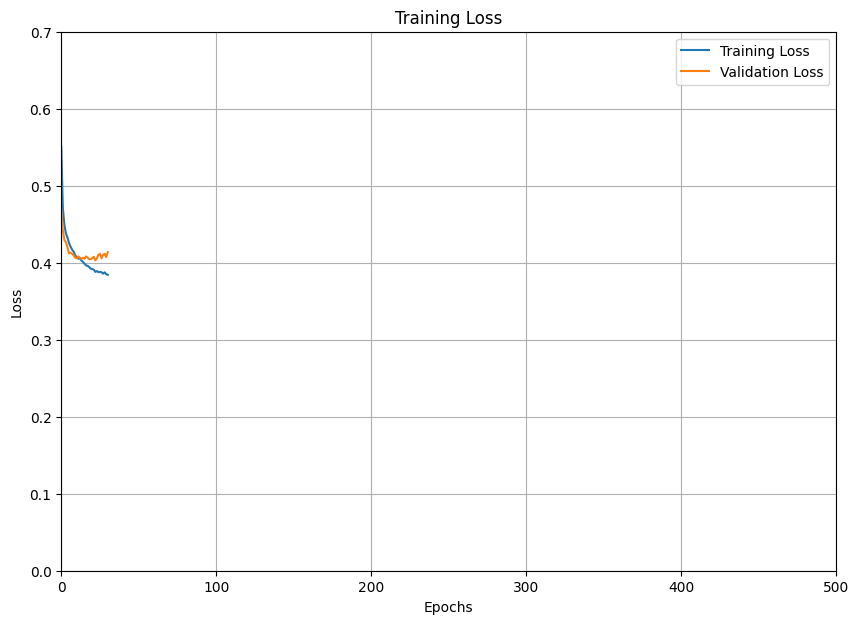

KeyboardInterrupt: 

In [29]:
#training loop
train_loader, x_test, y_test, x_validation, y_validation = prep_data(l_al, a_al, batch_size = 32, shuffle = True)

n_neurons_in = x_test.shape[2]
print('n_neurons:', n_neurons_in)
model_left = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 64, output_dim = 80, num_layers = 1, dropout = 0.1)
model_skip_left = SpikingAttentionSkipConnection(input_dim = n_neurons_in, hidden_dim = 32, output_dim = 80, num_layers = 2)

criterion = mse_loss
loss_history_left, vlidation_loss_history_left = train(model_left, train_loader, x_validation, y_validation,
                 criterion, epochs = 500, lr = 0.005, patience = 200)

y_pred_trained_l = model_left(x_test).detach().numpy()
print('y_pred shape:', y_pred_trained_l.shape)


this is overfitting - still working to resolve this

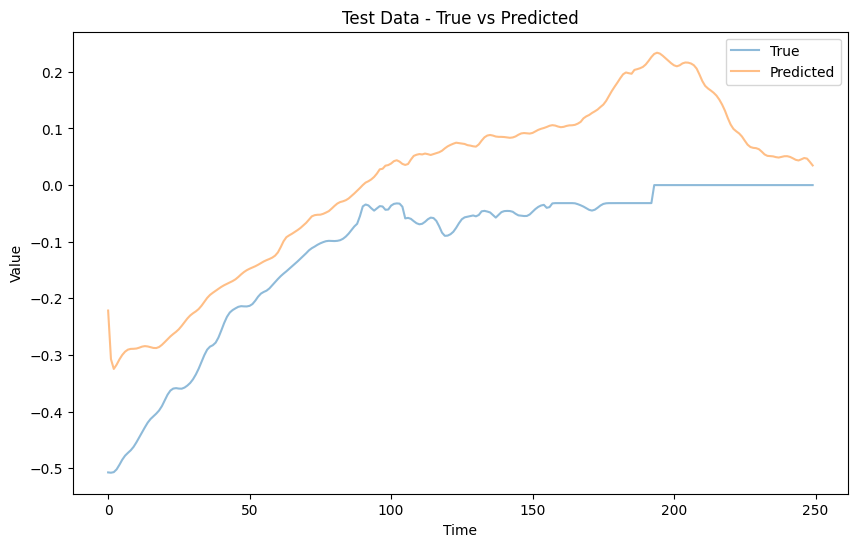

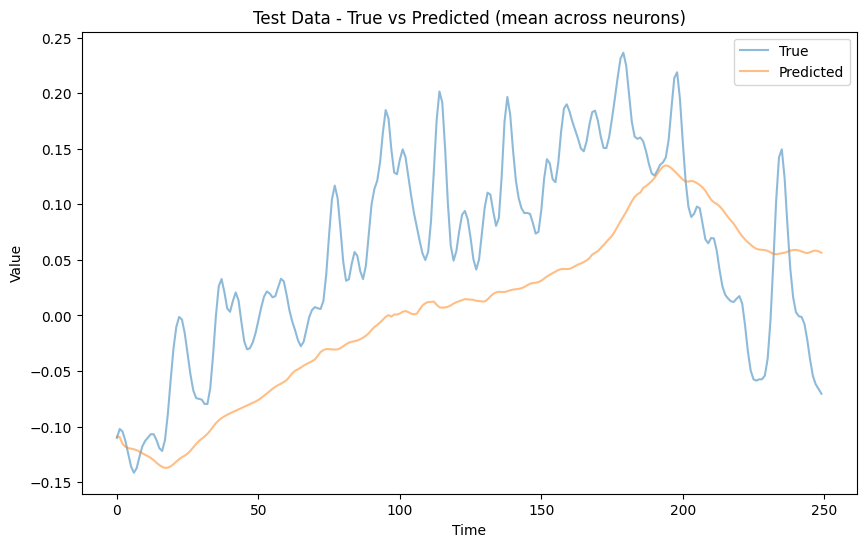

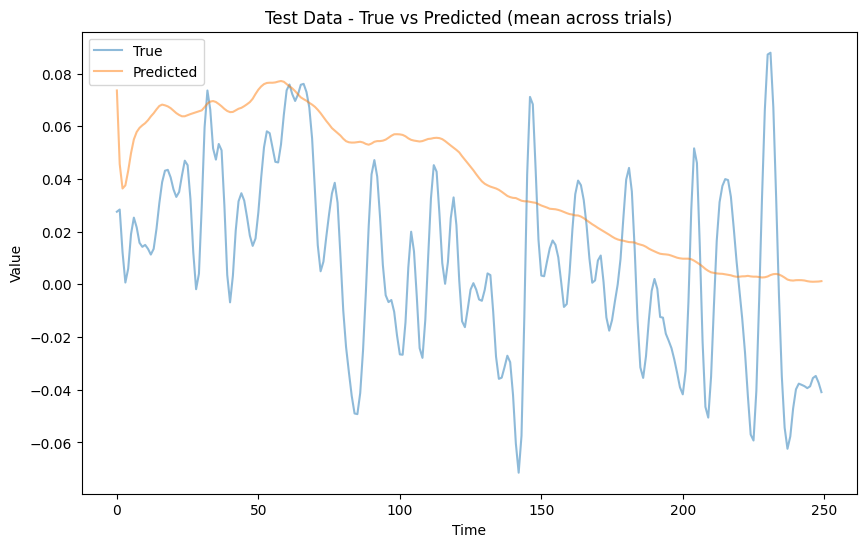

Pearson correlation coefficient: 0.6129882449745272
R^2: -0.5338374376296997
RMSE: 0.030075453


In [ ]:
trial = 4
neuron = 2

plot_results(
    y_test[trial, :, neuron], y_pred_trained_l[trial, :, neuron],
    'Test Data - True vs Predicted'
)

plot_results(
    y_test[trial].mean(axis = 1), y_pred_trained_l[trial].mean(axis = 1),
    'Test Data - True vs Predicted (mean across neurons)'
)

plot_results(
    y_test[:, :, neuron].mean(axis = 0), y_pred_trained_l[:, :, neuron].mean(axis = 0),
    'Test Data - True vs Predicted (mean across trials)'
)

show_stats(y_test, y_pred_trained_l)

In [ ]:
#training loop
_, _, r_al, _, a_al, _ = collect_data(file_numbers = [1, 2, 4])
train_loader, x_test, y_test, x_validation, y_validation = prep_data(l_al, r_al, batch_size=32, shuffle = True)

n_neurons_in = x_test.shape[2]
print('n_neurons:', n_neurons_in)
model_right = SpikingAttentionLSTM(input_dim = n_neurons_in, hidden_dim = 64, output_dim = 80, num_layers = 1)
# model_skip_right = SpikingAttentionSkipConnection(input_dim = n_neurons_in, hidden_dim = 64, output_dim = 80, num_layers = 1)

criterion = combined_loss()

loss_history_right, vlidation_loss_history_right = train(model_right, train_loader, x_validation, y_validation,
                 criterion, epochs = 2000, lr = 0.01, patience = 30)

y_pred_trained_r = model_right(x_test).detach().numpy()
print('y_pred shape:', y_pred_trained_r.shape)

In [ ]:
trial = 4
neuron = 2

plot_results(
    y_test[trial, :, neuron], y_pred_trained_r[trial, :, neuron],
    'Test Data - True vs Predicted'
)

plot_results(
    y_test[trial].mean(axis = 1), y_pred_trained_r[trial].mean(axis = 1),
    'Test Data - True vs Predicted (mean across neurons)'
)

show_stats(y_test, y_pred_trained_r)